In [1]:
import time
import cv2
import struct
import datetime
import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist
from skimage.feature import hog, local_binary_pattern
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, ExpSineSquared, DotProduct, WhiteKernel

In [2]:
DATA_FOLDER = "smallNORB/"

PREFIXES = {
    'train': 'smallnorb-5x46789x9x18x6x2x96x96-training-',
    'test': 'smallnorb-5x01235x9x18x6x2x96x96-testing-',
}

FILE_TYPES = ['info', 'cat', 'dat']

def read_int(f):
    num, = struct.unpack('i', f.read(4))
    return num

map_magic_number_to_data_type = {
    '1e3d4c55': np.uint8,
    '1e3d4c54': np.int32,
}

loaded_data = {}

for dataset, prefix in PREFIXES.items():
    for filetype in FILE_TYPES:
        filename = prefix + filetype + ".mat"
        print('Reading {}'.format(filename))
        
        file_loc = DATA_FOLDER + filename
        with open( file_loc, 'rb') as f:
            # Read the magic_num, convert it to hexadecimal, and look up the data_type
            raw_magic_num = read_int(f)
            magic_num = format(raw_magic_num, '02x')
            data_type = map_magic_number_to_data_type[magic_num]
            print('dtype', data_type)

            # Read how many dimensions to expect
            ndim = read_int(f)
            
            # Read at least 3 ints, or however many ndim there are
            shape = [
                read_int(f)
                for i in range(max(ndim, 3))
            ]   
            # But in case ndims < 3, take at most n_dim elements
            shape = shape[:ndim]
            print('shape', shape)
    
            # Now load the actual data!
            loaded_data[(dataset, filetype)] = np.fromfile(
                f, 
                dtype=data_type, 
                count=np.prod(shape)
            ).reshape(shape)

Reading smallnorb-5x46789x9x18x6x2x96x96-training-info.mat
dtype <class 'numpy.int32'>
shape [24300, 4]
Reading smallnorb-5x46789x9x18x6x2x96x96-training-cat.mat
dtype <class 'numpy.int32'>
shape [24300]
Reading smallnorb-5x46789x9x18x6x2x96x96-training-dat.mat
dtype <class 'numpy.uint8'>
shape [24300, 2, 96, 96]
Reading smallnorb-5x01235x9x18x6x2x96x96-testing-info.mat
dtype <class 'numpy.int32'>
shape [24300, 4]
Reading smallnorb-5x01235x9x18x6x2x96x96-testing-cat.mat
dtype <class 'numpy.int32'>
shape [24300]
Reading smallnorb-5x01235x9x18x6x2x96x96-testing-dat.mat
dtype <class 'numpy.uint8'>
shape [24300, 2, 96, 96]


In [3]:
loaded_data.keys()

dict_keys([('train', 'info'), ('train', 'cat'), ('train', 'dat'), ('test', 'info'), ('test', 'cat'), ('test', 'dat')])

In [4]:
x_train = np.squeeze(loaded_data[('train', 'dat')][:,:1])
y_train = loaded_data[('train', 'cat')]
x_test = np.squeeze(loaded_data[('test', 'dat')][:,:1])
y_test = loaded_data[('test', 'cat')]
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(24300, 96, 96)
(24300,)
(24300, 96, 96)
(24300,)


In [5]:
label = ['animal', 'human', 'plane', 'truck', 'car']

In [6]:
def showimage(image, train):
    if train == True:
        plt.imshow(x_train[image], cmap = 'gray')
        plt.axis('off')
        plt.show()
        return (label[y_train[image]])
    else:
        plt.imshow(x_test[image], cmap = 'gray')
        plt.axis('off')
        plt.show()
        return (label[y_test[image]])

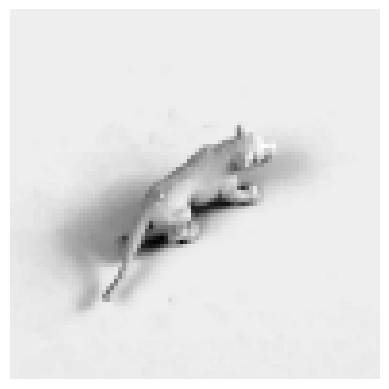

'animal'

In [13]:
showimage(0,1)

# Flatten

In [14]:
def flatten(train, test):
    
    return train.reshape(train.shape[0], -1), test.reshape(test.shape[0], -1)

# PCA

In [16]:
def pca(train, test, variance):
    
    train_flatten, test_flatten = flatten(train, test)
    
    pca = PCA(n_components = variance)
    pca.fit(train_flatten)
    
    return pca.transform(train_flatten), pca.transform(test_flatten)

# SIFT

In [18]:
def sift(train, test, num_cluster):
    
    sift = cv2.SIFT_create()
    
    sift_descriptors_train = []
    for image in train:
        kp, des = sift.detectAndCompute(image, None)
        sift_descriptors_train.append(des)
        
    sift_descriptors_test = []
    for image in test:
        kp, des = sift.detectAndCompute(image, None)
        sift_descriptors_test.append(des)
        
    sift_all_descriptors = []
    for descriptor in sift_descriptors_train:
        if descriptor is not None:
            for des in descriptor:
                sift_all_descriptors.append(des)
                
    sift_bow_dict = []
    kmeans = KMeans(n_clusters = num_cluster)
    kmeans.fit(sift_all_descriptors)
    sift_bow_dict = kmeans.cluster_centers_
    
    train_sift = []
    for image in sift_descriptors_train:
        features = np.array([0] * num_cluster)
        if image is not None:
            distance = cdist(image, sift_bow_dict)
            argmin = np.argmin(distance, axis = 1)
            for i in argmin:
                features[i] += 1
        train_sift.append(features)

    test_sift = []
    for image in sift_descriptors_test:
        features = np.array([0] * num_cluster)
        if image is not None:
            distance = cdist(image, sift_bow_dict)
            argmin = np.argmin(distance, axis = 1)
            for i in argmin:
                features[i] += 1
        test_sift.append(features)
        
    return np.array(train_sift), np.array(test_sift)

# HOG

In [20]:
def c_hog(train, test, orientations, ppc, cpb):
    
    train_hog = []
    test_hog = []

    for image in train:
        fd, hog_image = hog(image, orientations=orientations, pixels_per_cell=(ppc,ppc), cells_per_block=(cpb, cpb), visualize=True)
        train_hog.append(fd)

    for image in test:
        fd, hog_image = hog(image, orientations=orientations, pixels_per_cell=(ppc,ppc), cells_per_block=(cpb, cpb), visualize=True)
        test_hog.append(fd)
        
    return np.array(train_hog), np.array(test_hog)

# LBP

In [22]:
def lbp(train, test, radius, flat):

    train_lbp = []
    test_lbp = []

    for image in train:
        lbp = local_binary_pattern(image, 8 * radius, radius, 'uniform')
        train_lbp.append(lbp)

    for image in test:
        lbp = local_binary_pattern(image, 8 * radius, radius, 'uniform')
        test_lbp.append(lbp)
        
    train_lbp = np.array(train_lbp)
    test_lbp = np.array(test_lbp)
        
    if flat == True:
        return flatten(train_lbp.round().astype(np.uint8), test_lbp.round().astype(np.uint8))
    else:
        return train_lbp.round().astype(np.uint8), test_lbp.round().astype(np.uint8)

# SIFT + LBP

In [25]:
def siftlbp(train, test, num_cluster, radius):
    
    train_siftlbp, test_siftlbp = lbp(train, test, radius, 0)
    
    return sift(train_siftlbp, test_siftlbp, num_cluster)

# HOG + LBP

In [27]:
def hoglbp(train, test, orientations, ppc, cpb, radius):
    
    train_hoglbp, test_hoglbp = lbp(train, test, radius, 0)
    
    return c_hog(train_hoglbp, test_hoglbp, orientations, ppc, cpb)

# Gaussian Process

In [ ]:
train_gpc, test_gpc = siftlbp(x_train, x_test, 25, 3)

In [ ]:
print(train_gpc.shape)
print(test_gpc.shape)

In [ ]:
N = 2500
x = train_gpc[:N]
y = y_train[:N]

In [ ]:
start = time.time()
kernel = RationalQuadratic()
gpc = GaussianProcessClassifier(kernel=kernel)
gpc.fit(x, y)
end = time.time()
print(datetime.timedelta(seconds = int(end-start)))

In [ ]:
y_pred = gpc.predict(test_gpc)
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))